In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [11]:
#train_df = pd.read_csv("Apr-04-2021.csv", index_col=0)
train_df = pd.read_csv("client-retry-vn-3.csv")
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
0,0,quant,client,quic_client_test_version_negociation0,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
1,1,quant,client,quic_client_test_retry0,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
2,2,quant,client,quic_client_test_version_negociation0,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
3,3,quant,client,quic_client_test_retry0,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,4,quant,client,quic_client_test_retry0,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0


In [12]:
train_df = train_df[train_df.Mode != 'server']

In [13]:
server_name = train_df.Implementation.unique()
servers = []
print(server_name)
servers = []
for i, row in train_df.iterrows():
    resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
    splited = resultFile.split("/")
    resultFile = splited[0] +"/"+ splited[1] + "/res_client.txt"
    #print(resultFile)
    if os.path.isfile(resultFile): 
        f = open(resultFile, "r", encoding="ISO-8859-1")
        s = f.read()
        #print(s)
        if "cargo run --manifest-path=tools/apps/Cargo.toml" in s:
            train_df.loc[i, "Implementation"] = "quiche"
        elif "cargo run" in s:
            train_df.loc[i, "Implementation"] = "quinn"
        elif "./http_server" in s:
            train_df.loc[i, "Implementation"] = "lsquic"
        elif "./picoquicdemo" in s:
            train_df.loc[i, "Implementation"] = "picoquic"
        elif "./server -d" in s:
            train_df.loc[i, "Implementation"] = "quant"
        elif "./server -c" in s:
            train_df.loc[i, "Implementation"] = "quic-go"
        elif "python3 examples/" in s:
            train_df.loc[i, "Implementation"] = "aioquic"
        elif "echo" in s:
            train_df.loc[i, "Implementation"] = "mvfst"
        
#print(servers)
print(train_df.Implementation.unique())
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)

for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")

train_df.head()

['quant' 'picoquic']
['aioquic' 'quant' 'picoquic' 'quiche' 'quinn' 'mvfst']


,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
0,0,aioquic,client,quic_client_test_version_negociation,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
1,1,quant,client,quic_client_test_retry,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
2,2,quant,client,quic_client_test_version_negociation,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
3,3,quant,client,quic_client_test_retry,NaN,"ivy_return_code(1)+assumption_failed(""/usr/loc...",/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,4,quant,client,quic_client_test_retry,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0


In [18]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_client_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "timeout+binding id:" in content :
            train_df.loc[i, "ErrorIEV"] = "Timeout"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif "timeout+binding id:" in row["ErrorIEV"] :
            train_df.loc[i, "ErrorIEV"] = "Timeout binding ID"
        elif "timeout+sending id:" in row["ErrorIEV"] :
            train_df.loc[i, "ErrorIEV"] = "Timeout sending ID"
        elif "< undecryptable_packet_event" in row["ErrorIEV"] :
            train_df.loc[i, "ErrorIEV"] = "undecryptable_packet_event"
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"
        
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
0,0,aioquic,client,quic_client_test_version_negociation,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
1,1,quant,client,quic_client_test_retry,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
2,2,quant,client,quic_client_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
3,3,quant,client,quic_client_test_retry,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,4,quant,client,quic_client_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0


In [8]:
train_df.TestName.unique()

array(['quic_client_test_max', 'quic_client_test_tp_error',
       'quic_client_test_double_tp_error',
       'quic_client_test_tp_acticoid_error',
       'quic_client_test_tp_limit_acticoid_error',
       'quic_client_test_retirecoid_error',
       'quic_client_test_newcoid_zero_error',
       'quic_client_test_accept_maxdata',
       'quic_client_test_tp_prefadd_error', 'quic_client_test_no_odci',
       'quic_client_test_ext_min_ack_delay',
       'quic_client_test_token_error'], dtype=object)

In [19]:
train_df["ErrorIEV"].unique().tolist()

['+',
 'Handshake not completed',
 'No Error',
 'server_return_code(127)+timeout',
 'server_return_code(1)+timeout',
 'server_return_code(134)+timeout',
 'frame.connection_close:{err_code:0}',
 'server_return_code(2)+timeout',
 'undecryptable_packet_event']

In [20]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/client-retry-vn-3/"):]
            i = i.split("/")[0]
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "client-retry-vn-3/" + str(i) + "_" + row["Implementation"] + "_" + str(row["TestName"]) + ".pcap"
                if os.path.isfile(resultFile):
                    try:
                        packets = rdpcap(resultFile)
                        ln = len(packets)
                        df.loc[index, "NbPktSend"] = ln
                    except:
                        pass
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="client_processed.csv",index=False)
    j += size
    

train_df.head()

1518
151
11



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
0,0,aioquic,client,quic_client_test_version_negociation,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
1,1,quant,client,quic_client_test_retry,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
2,2,quant,client,quic_client_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,19.0,0.0
3,3,quant,client,quic_client_test_retry,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,4,quant,client,quic_client_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,78.0,1.0


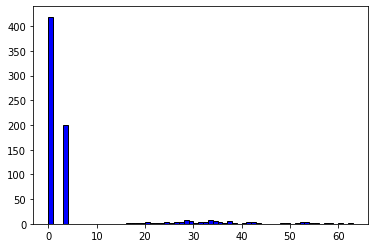

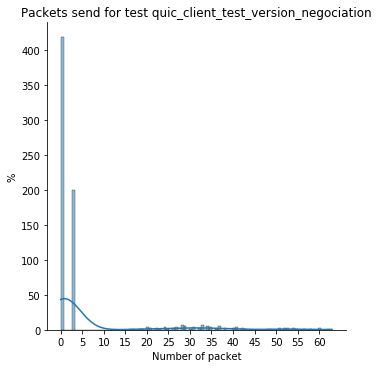

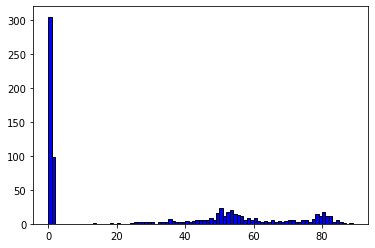

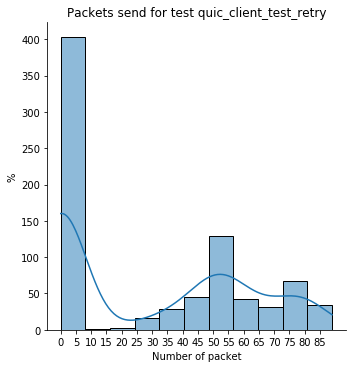

In [21]:
tests = train_df.TestName.unique()
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    #plt.savefig(filename)
    plt.show()

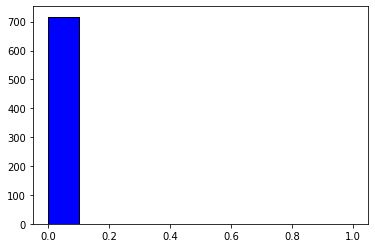

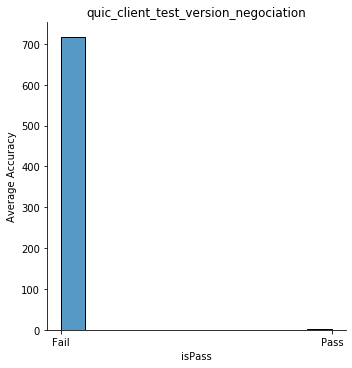

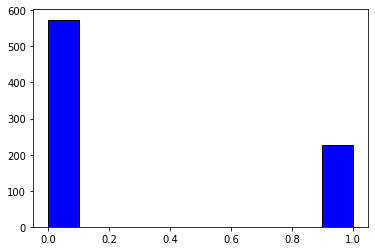

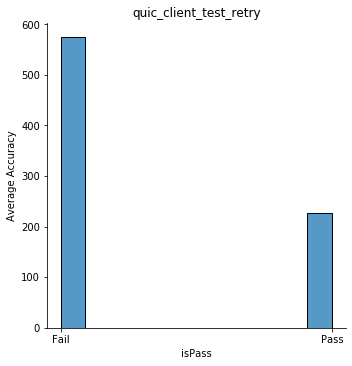

In [22]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

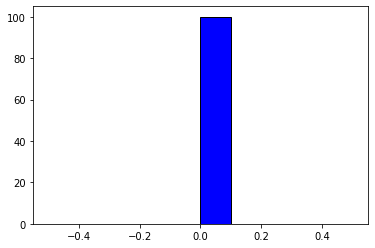

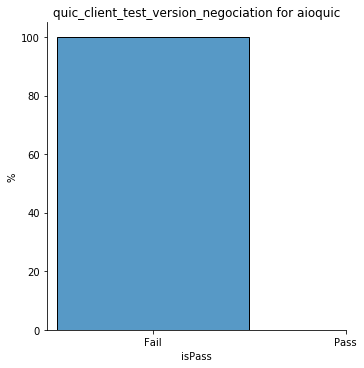

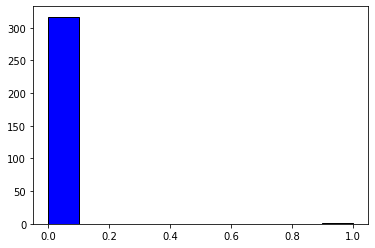

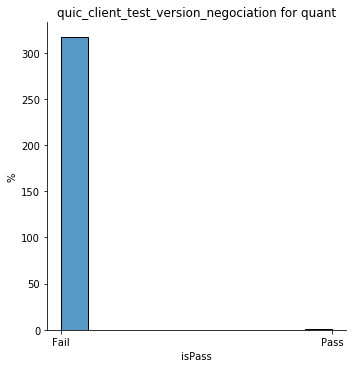

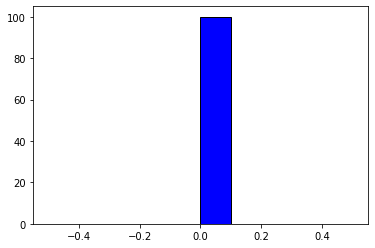

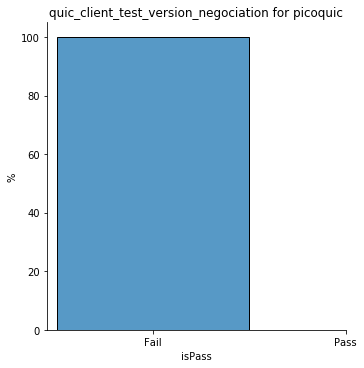

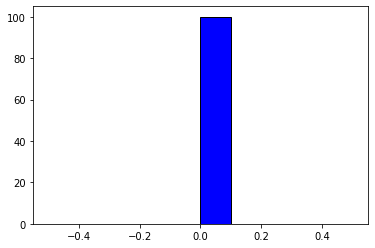

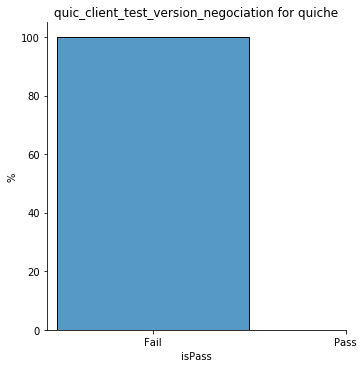

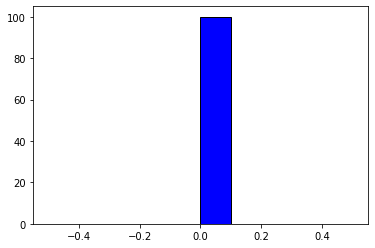

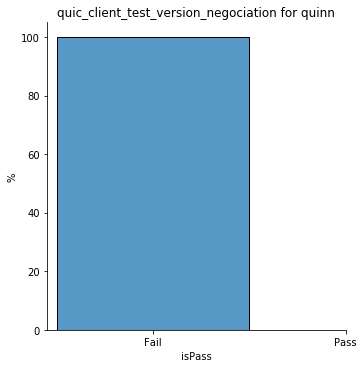

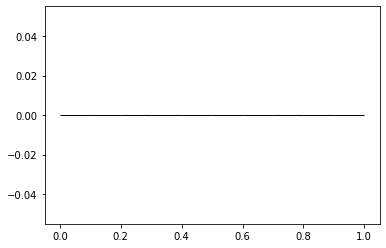

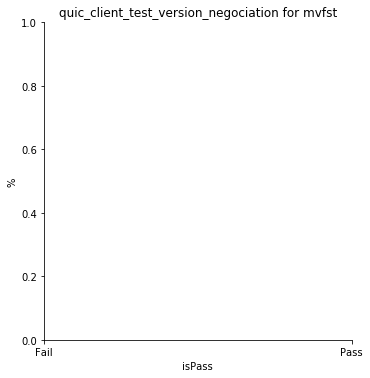

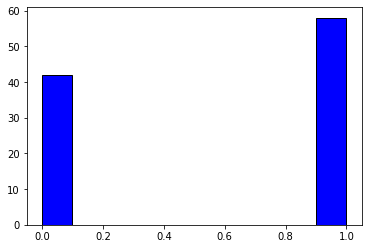

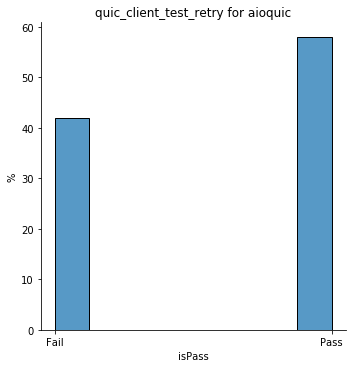

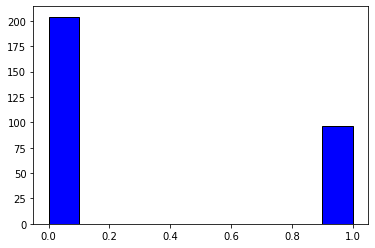

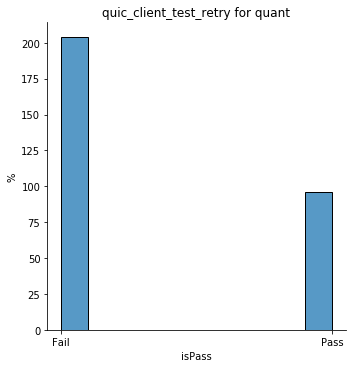

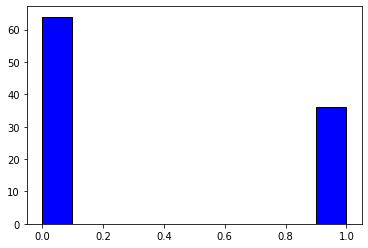

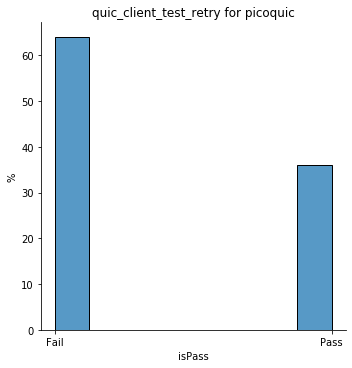

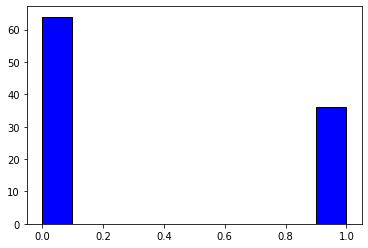

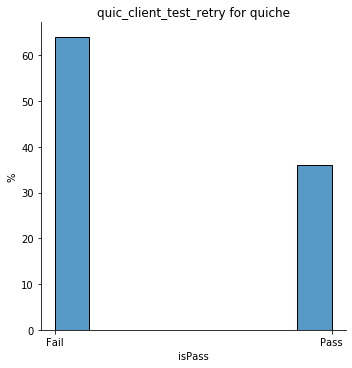

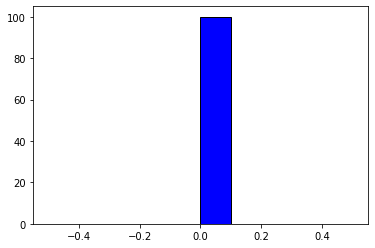

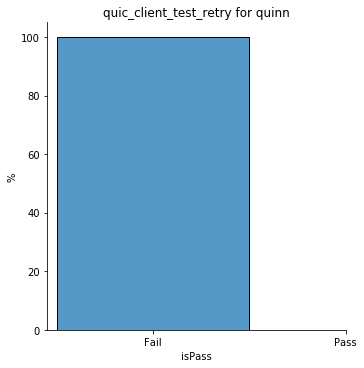

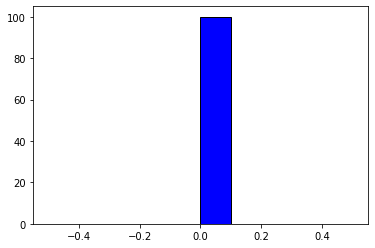

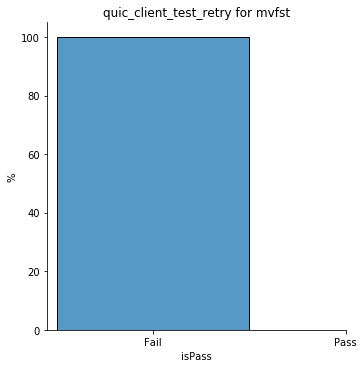

In [23]:
tests = train_df.TestName.unique()

servers = train_df.Implementation.unique()
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.displot(subsubdf['isPass'], kde=False)
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        #plt.savefig(filename)

        plt.show()
    

In [24]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

aioquic
200
58.0

quant
618
97.0

picoquic
200
36.0

quiche
200
36.0

quinn
200
0.0

mvfst
100
0.0



In [25]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    for s in tests:
        ssubdf = subdf.loc[subdf['TestName'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

aioquic
quic_client_test_version_negociation
100
0.0

aioquic
quic_client_test_retry
100
58.0

quant
quic_client_test_version_negociation
318
1.0

quant
quic_client_test_retry
300
96.0

picoquic
quic_client_test_version_negociation
100
0.0

picoquic
quic_client_test_retry
100
36.0

quiche
quic_client_test_version_negociation
100
0.0

quiche
quic_client_test_retry
100
36.0

quinn
quic_client_test_version_negociation
100
0.0

quinn
quic_client_test_retry
100
0.0

mvfst
quic_client_test_version_negociation
0
0.0

mvfst
quic_client_test_retry
100
0.0



quic_client_test_version_negociation
aioquic
['+', 'server_return_code(2)+timeout']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


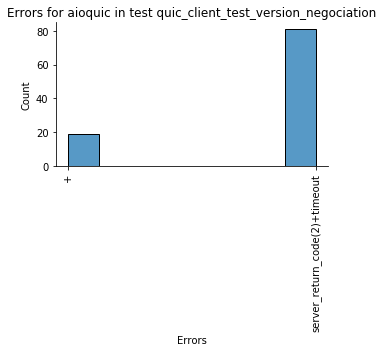

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_retry
aioquic
['No Error', 'Handshake not completed']


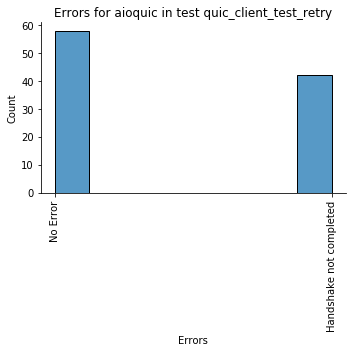

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_version_negociation
quant
['Handshake not completed', 'server_return_code(127)+timeout', '+', 'server_return_code(134)+timeout', 'No Error', 'undecryptable_packet_event']


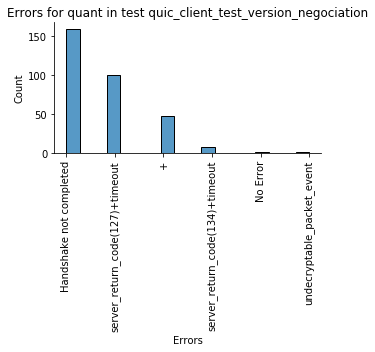

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_retry
quant
['Handshake not completed', 'No Error', 'server_return_code(127)+timeout', 'frame.connection_close:{err_code:0}']


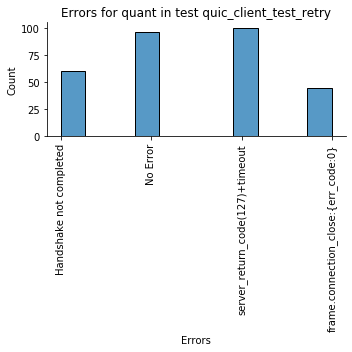

quic_client_test_version_negociation
picoquic
['Handshake not completed']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


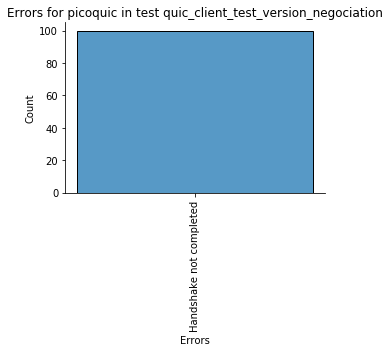

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_retry
picoquic
['Handshake not completed', 'No Error']


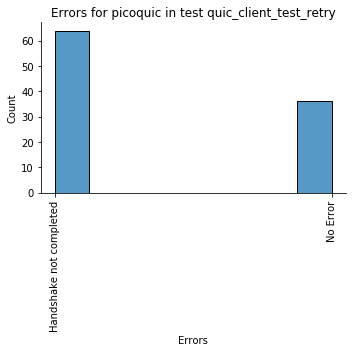

quic_client_test_version_negociation
quiche
['Handshake not completed']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


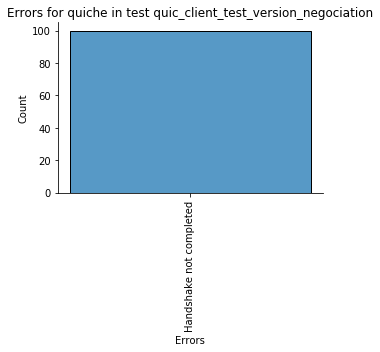

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_retry
quiche
['No Error', 'Handshake not completed']


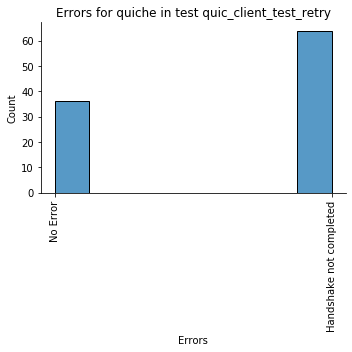

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_client_test_version_negociation
quinn
['server_return_code(1)+timeout']


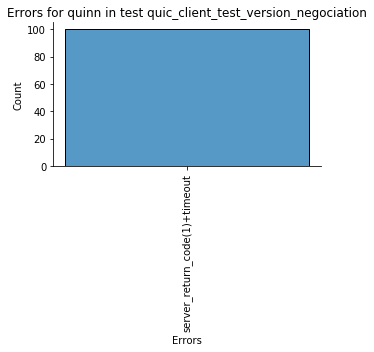

quic_client_test_retry
quinn
['server_return_code(1)+timeout']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


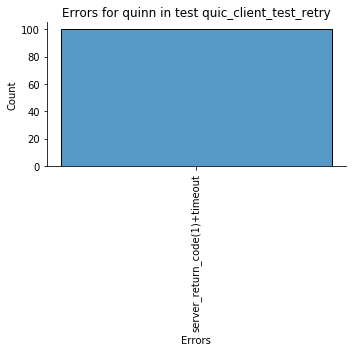

quic_client_test_version_negociation
mvfst
[]


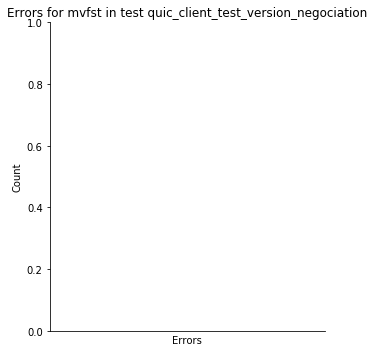

quic_client_test_retry
mvfst
['server_return_code(134)+timeout', 'Handshake not completed']


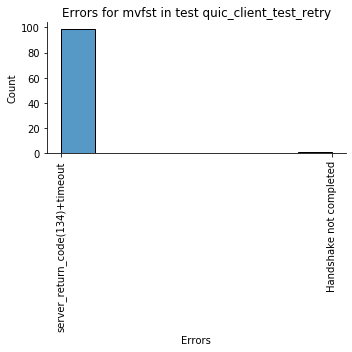

In [27]:
all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for s in servers:
    subdf = train_df.loc[train_df['Implementation'] == s]
    for t in tests:
        subsubdf = subdf.loc[subdf['TestName'] == t]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
                
        # seaborn histogram
        sns.displot(x=subsubdf['ErrorsCode'],  kde=False ) #,hue="Implementation"
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.gcf()
        plt.tight_layout()
        #fig.set_size_inches(20,20)
        #plt.savefig(filename, dpi=fig.dpi*2)
        plt.show()

In [12]:
for i, row in train_df.iterrows():
    resultFile = "client-result" + row["OutputFile"][8:]
    f = open(resultFile, "r")
    content = f.read()
    if "TEST_SCIL " in content:
        start_index = content.find("TEST_SCIL ")
        end_index = content.find("\n",start_index)
        scil = int(content[start_index+len("TEST_DCIL "):end_index+1].replace("\n","")) 
        if scil > 16:
            train_df.drop(train_df.index,axis=0)
    if "TEST_DCIL " in content:
        start_index = content.find("TEST_DCIL ")
        end_index = content.find("\n",start_index)
        dcil = int(content[start_index+len("TEST_DCIL "):end_index+1].replace("\n","")) 
        if dcil > 16:
            train_df.drop(train_df.index,axis=0)

train_df.to_csv(path_or_buf="client_processed_cid.csv",index=False)

train_df.head()

In [28]:
tests = train_df.TestName.unique()
servers = train_df.Implementation.unique()
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

aioquic
200
58.0

quant
618
97.0

picoquic
200
36.0

quiche
200
36.0

quinn
200
0.0

mvfst
100
0.0



In [29]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    for s in tests:
        ssubdf = subdf.loc[subdf['TestName'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

aioquic
quic_client_test_version_negociation
100
0.0

aioquic
quic_client_test_retry
100
58.0

quant
quic_client_test_version_negociation
318
1.0

quant
quic_client_test_retry
300
96.0

picoquic
quic_client_test_version_negociation
100
0.0

picoquic
quic_client_test_retry
100
36.0

quiche
quic_client_test_version_negociation
100
0.0

quiche
quic_client_test_retry
100
36.0

quinn
quic_client_test_version_negociation
100
0.0

quinn
quic_client_test_retry
100
0.0

mvfst
quic_client_test_version_negociation
0
0.0

mvfst
quic_client_test_retry
100
0.0

